In [ ]:
#This code uses 3D Unet to train a network on 3D subvolumes (64x64x64).
#It also segments a large volume and outputs a multidimensional OMETIFF file
#Custom dataset is used for this code but it should work on any dataset, including BRATS.

In [ ]:
#Latest Tensorflow (2.4) is giving error for some of the libraries we will be using, 
# especially segmentation models 3D. 
#Therefore, I am defining TF version 1.x. 
#If you have your own 3D unet model, you can try the latest TF version.
%tensorflow_version 1.x

In [ ]:
#Install all dependencies for sgementation-models-3D library.
#We will use this library to call 3D unet.
#Alternative, you can define your own Unet, if you have skills!
!pip install classification-models-3D
!pip install efficientnet-3D
!pip install segmentation-models-3D

In [ ]:
#Use patchify to break large volumes into smaller for training 
#and also to put patches back together after prediction.
!pip install patchify

In [ ]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

In [ ]:
#Make sure the GPU is available. 
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
import segmentation_models_3D as sm


In [8]:
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [9]:
#Load input images and masks. 
#Here we load 256x256x256 pixel volume. We will break it into patches of 64x64x64 for training. 
image = io.imread('/content/drive/MyDrive/Colab Notebooks/data/sandstone_3d/training_data/train_images_256_256_256.tif')
img_patches = patchify(image, (64, 64, 64), step=64)  #Step=64 for 64 patches means no overlap

mask = io.imread('/content/drive/MyDrive/Colab Notebooks/data/sandstone_3d/training_data/train_masks_256_256_256.tif')
mask_patches = patchify(mask, (64, 64, 64), step=64)  


In [ ]:
plt.imshow(img_patches[1,2,3,:,:,32])
#plt.imshow(mask_patches[1,2,3,:,:,32])

In [ ]:

input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

print(input_img.shape)  # n_patches, x, y, z



In [12]:
n_classes=4

In [13]:
#Convert grey image to 3 channels by copying channel 3 times.
#We do this as our unet model expects 3 channel input. 

train_img = np.stack((input_img,)*3, axis=-1)
train_mask = np.expand_dims(input_mask, axis=4)


train_mask_cat = to_categorical(train_mask, num_classes=n_classes)


X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.10, random_state = 0)



In [14]:

# Loss Function and coefficients to be used during training:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


Backbones: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']

In [ ]:
#Define parameters for our model.

encoder_weights = 'imagenet'
BACKBONE = 'vgg16'  #Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'softmax'
patch_size = 64
n_classes = 4
channels=3

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [16]:
preprocess_input = sm.get_preprocessing(BACKBONE)

In [17]:
#Preprocess input data - otherwise you end up with garbage resutls 
# and potentially model that does not converge.
X_train_prep = preprocess_input(X_train)
X_test_prep = preprocess_input(X_test)

In [ ]:
#Define the model. Here we use Unet but we can also use other model architectures from the library.
model = sm.Unet(BACKBONE, classes=n_classes, 
                input_shape=(patch_size, patch_size, patch_size, channels), 
                encoder_weights=encoder_weights,
                activation=activation)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

In [ ]:
#Fit the model
history=model.fit(X_train_prep, 
          y_train,
          batch_size=8, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prep, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 57 samples, validate on 7 samples
Epoch 1/100
57/57 [==============================] - 42s 735ms/step - loss: 1.0129 - iou_score: 0.0845 - f1-score: 0.1436 - val_loss: 1.4637 - val_iou_score: 0.0412 - val_f1-score: 0.0750
Epoch 2/100
57/57 [==============================] - 14s 244ms/step - loss: 0.9787 - iou_score: 0.1936 - f1-score: 0.2965 - val_loss: 1.2845 - val_iou_score: 0.0531 - val_f1-score: 0.0951
Epoch 3/100
57/57 [==============================] - 14s 246ms/step - loss: 0.9565 - iou_score: 0.3277 - f1-score: 0.4564 - val_loss: 1.0878 - val_iou_score: 0.0956 - val_f1-score: 0.1649
Epoch 4/100
57/57 [==============================] - 14s 249ms/step - loss: 0.9421 - iou_score: 0.3731 - f1-score: 0.4933 - val_loss: 1.0750 - val_iou_score: 0.1062 - val_f1-score: 0.1784
Epoch 5/100
57/57 [==============================] - 14s 253ms/step - loss: 0.9300 - iou_score: 0.4231 - f1-sc

In [ ]:
#Save model for future use
model.save('/content/drive/MyDrive/Colab Notebooks/data/sandstone_3d/3D_model_vgg16_100epochs.h5')

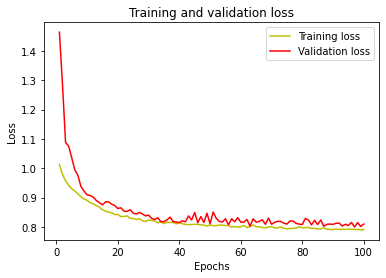

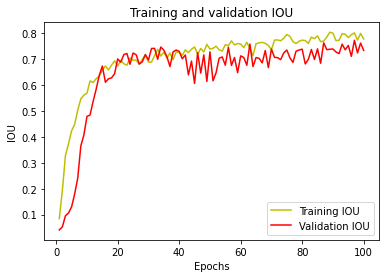

In [ ]:
###
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [19]:
#Load the pretrained model for testing and predictions. 
from keras.models import load_model
my_model = load_model('/content/drive/MyDrive/Colab Notebooks/data/sandstone_3d/3D_model_vgg16_100epochs.h5', compile=False)
#If you load a different model do not forget to preprocess accordingly. 

In [21]:
#Predict on the test data
y_pred=my_model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=4)
y_test_argmax = np.argmax(y_test, axis=4)


In [ ]:
print(y_pred_argmax.shape)
print(y_test_argmax.shape)
print(np.unique(y_pred_argmax))

In [ ]:
#Using built in keras function for IoU
#Only works on TF > 2.0
#from keras.metrics import MeanIoU
#from keras.metrics import MeanIoU
#n_classes = 4
#IOU_keras = MeanIoU(num_classes=n_classes)  
#IOU_keras.update_state(y_test_argmax, y_pred_argmax)
#print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input(test_img_input)

test_pred1 = my_model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=4)[0,:,:,:]
print(test_prediction1.shape)




In [ ]:
ground_truth_argmax = np.argmax(ground_truth, axis=3)
print(test_img.shape)

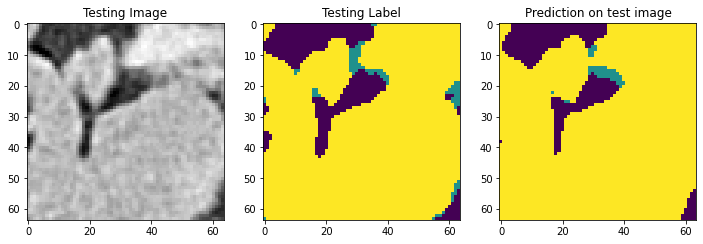

In [25]:
#Plot individual slices from test predictions for verification
slice = 14
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1[slice,:,:])
plt.show()

Now segment the full volume using the trained model.

In [ ]:
#Break the large image (volume) into patches of same size as the training images (patches)
large_image = io.imread('/content/drive/MyDrive/Colab Notebooks/data/sandstone_3d/all_images/448_images_512x512.tif')
patches = patchify(large_image, (64, 64, 64), step=64)  #Step=256 for 256 patches means no overlap
print(large_image.shape)
print(patches.shape)

In [27]:
# Predict each 3D patch   
predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      #print(i,j,k)
      single_patch = patches[i,j,k, :,:,:]
      single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
      single_patch_3ch_input = preprocess_input(np.expand_dims(single_patch_3ch, axis=0))
      single_patch_prediction = my_model.predict(single_patch_3ch_input)
      single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_prediction_argmax)
      


In [ ]:
#Convert list to numpy array
predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

In [ ]:
#Reshape to the shape we had after patchifying
predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (patches.shape[0], patches.shape[1], patches.shape[2],
                                         patches.shape[3], patches.shape[4], patches.shape[5]) )
print(predicted_patches_reshaped.shape)

In [ ]:
#Repach individual patches into the orginal volume shape
reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
print(reconstructed_image.shape)

In [ ]:
print(reconstructed_image.dtype)

In [ ]:
#Convert to uint8 so we can open image in most image viewing software packages
reconstructed_image=reconstructed_image.astype(np.uint8)
print(reconstructed_image.dtype)

In [ ]:
#Now save it as segmented volume.
from tifffile import imsave
imsave('/content/drive/MyDrive/Colab Notebooks/data/sandstone_3d/all_images/segmented.tif', reconstructed_image)
    

In [ ]:
#If you would like to save the volume as multichannel dataset....

In [ ]:
print(np.unique(reconstructed_image))

In [34]:
#Seperate each channel/segment to be combined as multiple channels.
num_segments=4
segm0 = (reconstructed_image == 0)
segm1 = (reconstructed_image == 1)
segm2 = (reconstructed_image == 2)
segm3 = (reconstructed_image == 3)

final = np.empty((reconstructed_image.shape[0], reconstructed_image.shape[1], reconstructed_image.shape[2], num_segments))
final[:,:,:,0] = segm0
final[:,:,:,1] = segm1
final[:,:,:,2] = segm2
final[:,:,:,3] = segm3

In [ ]:
#Use APEER OMETIFF library to read and write multidimensional images
!pip install apeer-ometiff-library

In [36]:
from apeer_ometiff_library import io

In [37]:
# Expand image array to 5D of order (T, Z, C, X, Y)
# This is the convention for OMETIFF format as written by APEER library
final = np.expand_dims(final, axis=0)
final=np.swapaxes(final, 2, 4)

final = final.astype(np.int8)



In [ ]:
print("Shape of the segmented volume is: T, Z, C, X, Y ", final.shape)
print(final.dtype)


In [ ]:
# Write dataset as multi-dimensional OMETIFF *image*
io.write_ometiff("/content/drive/MyDrive/Colab Notebooks/data/sandstone_3d/all_images/segmented_multi_channel.ome.tiff", final)